# **Nama  : Wilson Boyaron Hutagalung**
# **NIM   : 2209106035**

#### Link Dataset: https://www.kaggle.com/datasets/utkarshsaxenadn/car-vs-bike-classification-dataset

## Import Library
<P> Kodedibawah ini mengimpor berbagai library yang dibutuhkan untuk melakukan klasifikasi gambar mobil dan sepeda motor. Library yang digunakan meliputi tools untuk manipulasi file (os, shutil), pengolahan gambar (cv2), matematika dan array (numpy), machine learning (sklearn), ekstraksi fitur HOG, dan visualisasi hasil (matplotlib).<P>

In [1]:
import os
import shutil
import cv2
import random
import numpy as np
from sklearn.svm import SVC
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report, confusion_matrix, ConfusionMatrixDisplay
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import GridSearchCV
from skimage.feature import hog
import matplotlib.pyplot as plt
from sklearn.preprocessing import LabelEncoder

## Split DataSet
<p>Fungsi kode dibawah ini membagi dataset gambar menjadi tiga bagian (training 80%, validation 10%, dan testing 10%) dengan cara mengacak gambar dari setiap kelas terlebih dahulu. Kemudian gambar disalin ke struktur folder baru yang diorganisir berdasarkan jenis split dan kelas gambar, memastikan data tersebut siap untuk proses pelatihan model.<p> Untuk fungsi dibawah ini bisa di jadikan comment ketika sudah berhasil split data barunya.

In [ ]:
def split_dataset(original_dir, output_base_dir, train_ratio=0.8, val_ratio=0.1, test_ratio=0.1):
    assert train_ratio + val_ratio + test_ratio == 1.0, "Rasio harus total 1.0"
    
    classes = os.listdir(original_dir)
    
    for class_name in classes:
        class_path = os.path.join(original_dir, class_name)
        
        if not os.path.isdir(class_path):
            continue
        
        images = os.listdir(class_path)
        random.shuffle(images)  
        
        total = len(images)
        train_end = int(train_ratio * total)
        val_end = train_end + int(val_ratio * total)

        splits = {
            'train': images[:train_end],
            'val': images[train_end:val_end],
            'test': images[val_end:]
        }

        for split, split_images in splits.items():
            split_dir = os.path.join(output_base_dir, split, class_name)
            os.makedirs(split_dir, exist_ok=True)
            for img in split_images:
                src_path = os.path.join(class_path, img)
                dst_path = os.path.join(split_dir, img)
                shutil.copy2(src_path, dst_path)  #
        
    print("Dataset berhasil dibagi ke dalam folder Train, Val, dan Test.")

split_dataset('./Car-Bike-Dataset', './DataSet-CarBike')

## Fungsi Ekstraksi Fitur HOG
<p>Fungsi kode dibawah ini mengekstrak fitur Histogram of Oriented Gradients (HOG) dari setiap gambar dalam dataset. Setiap gambar diubah ke grayscale, diubah ukurannya menjadi 128x128 pixel, kemudian dianalisis untuk mendapatkan distribusi gradien yang menjadi fitur pembeda. HOG sangat efektif untuk mengenali bentuk dan struktur objek, memungkinkan model mengenali perbedaan bentuk antara mobil dan sepeda motor.<p>

In [3]:
def augment_image(img):
    img_rotated = cv2.rotate(img, cv2.ROTATE_90_CLOCKWISE)
    img_flipped = cv2.flip(img, 1) 
    return [img, img_rotated, img_flipped]
def extract_hog_features(directory, augment=False):
    features = []
    labels = []
    class_counts = {}
    
    for label in os.listdir(directory):
        class_path = os.path.join(directory, label)
        if not os.path.isdir(class_path):
            continue
        class_label = label.lower()
        class_counts[class_label] = 0
        
        for img_file in os.listdir(class_path):
            img_path = os.path.join(class_path, img_file)
            img = cv2.imread(img_path, cv2.IMREAD_GRAYSCALE)
            if img is None:
                continue
            img = cv2.resize(img, (128, 128))
            images_to_process = augment_image(img) if augment else [img]     
            for processed_img in images_to_process:
                hog_feature = hog(processed_img, orientations=12, pixels_per_cell=(16, 16),
                  cells_per_block=(3, 3), block_norm='L2-Hys', visualize=False)
                features.append(hog_feature)
                labels.append(class_label)
                class_counts[class_label] += 1
    
    print(f"Jumlah gambar per kelas di '{directory}': {class_counts}")
    return np.array(features), np.array(labels)

## Load Dataset
<p>Kode dibawah ini akan memuat dataset yang telah dibagi sebelumnya dan melakukan ekstraksi fitur HOG pada data training, validation, dan testing. Hasil yang diperoleh adalah fitur HOG (X) dan label (y) untuk ketiga jenis dataset yang akan digunakan dalam melatih dan mengevaluasi model.<p>

In [4]:
train_dir = './DataSet-CarBike/train'
val_dir = './DataSet-CarBike/val'
test_dir = './DataSet-CarBike/test'

X_train, y_train = extract_hog_features(train_dir, augment=True)
X_val, y_val = extract_hog_features(val_dir, augment=False)
X_test, y_test = extract_hog_features(test_dir, augment=False)

Jumlah gambar per kelas di './DataSet-CarBike/train': {'bike': 4800, 'car': 4800}
Jumlah gambar per kelas di './DataSet-CarBike/val': {'bike': 200, 'car': 200}
Jumlah gambar per kelas di './DataSet-CarBike/test': {'bike': 200, 'car': 200}


## Validasi Jumlah Kelas
<p>Kode dibawah ini akan memastikan bahwa dataset pelatihan memiliki lebih dari satu kelas jika tidak, akan muncul error karena klasifikasi memerlukan minimal dua kelas.<p>

In [5]:
unique_classes = np.unique(y_train)
if len(unique_classes) <= 1:
    raise ValueError(f"Dataset pelatihan hanya memiliki {len(unique_classes)} kelas. Pastikan dataset memiliki lebih dari satu kelas.")

## Encode Label
<p>Label string seperti "car" dan "bike" dikonversi menjadi format numerik menggunakan LabelEncoder agar dapat digunakan dalam algoritma pembelajaran mesin.<p>

In [6]:
le = LabelEncoder()
y_train_enc = le.fit_transform(y_train)
y_val_enc = le.transform(y_val)
y_test_enc = le.transform(y_test)

## Melakukan Normalisasi
<p>Fitur HOG yang telah diekstrak dinormalisasi menggunakan StandardScaler untuk memastikan semua fitur memiliki skala yang sama, meningkatkan performa model SVM.<p>

In [7]:
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_val_scaled = scaler.transform(X_val)
X_test_scaled = scaler.transform(X_test)

## Pelatihan Model SVM
<p>Pada kode kode dibawah ini tentang Model Support Vector Machine dilatih menggunakan data train yang telah diskalakan. Kernel RBF digunakan karena efektif untuk data non-linear, dengan parameter C=10 dan gamma=0.01.<p>

In [8]:
rf_model = RandomForestClassifier(
  n_estimators=200,  
    max_depth=20,     
    min_samples_split=5,
    random_state=42,
    n_jobs=-1       
)

rf_model.fit(X_train_scaled, y_train_enc)

RandomForestClassifier(max_depth=20, min_samples_split=5, n_estimators=200,
                       n_jobs=-1, random_state=42)

## Evaluasi Model
<p>Pada kode dibawah ini menunjukkan bahwa model yang telah dilatih diuji pada data validasi dan data pengujian. Hasilnya dilaporkan dalam bentuk classification report yang menunjukkan metrik seperti precision, recall, dan f1-score, serta akurasi.<p>

In [9]:
y_val_pred = rf_model.predict(X_val_scaled)
y_val_true_labels = le.inverse_transform(y_val_enc)
y_val_pred_labels = le.inverse_transform(y_val_pred)

print("\n=== Classification Report on Validation Data ===")
print(classification_report(y_val_true_labels, y_val_pred_labels, target_names=le.classes_))

# val_accuracy = svm_model.score(X_val_scaled, y_val_enc)
val_accuracy = rf_model.score(X_val_scaled, y_val_enc)
print(f"Validation Accuracy: {val_accuracy:.2f}")



=== Classification Report on Validation Data ===
              precision    recall  f1-score   support

        bike       0.92      0.88      0.90       200
         car       0.89      0.93      0.90       200

    accuracy                           0.90       400
   macro avg       0.90      0.90      0.90       400
weighted avg       0.90      0.90      0.90       400

Validation Accuracy: 0.90


In [10]:
accuracy = rf_model.score(X_test_scaled, y_test_enc)
print(f"Test Accuracy: {accuracy:.2f}")

Test Accuracy: 0.91


<!-- ## Model SVM -->
## Confusion Matrix
<p>Kode dibawah ini akan menampilkan confusion matrix menggunakan data validasi untuk memberikan gambaran visual seberapa banyak prediksi yang benar dan salah untuk masing-masing kelas.<p>

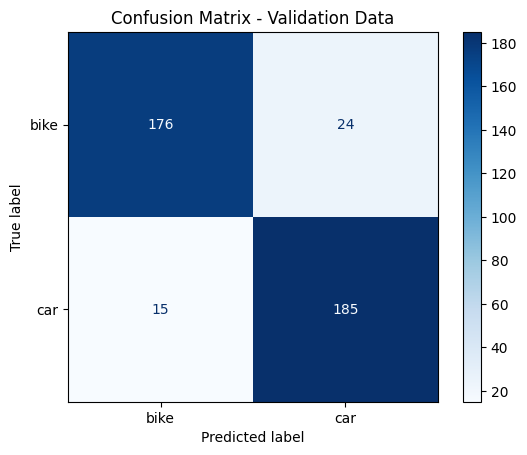

In [11]:

cm = confusion_matrix(y_val_enc, y_val_pred)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=le.classes_)
disp.plot(cmap=plt.cm.Blues)
plt.title("Confusion Matrix - Validation Data")
plt.show()

## Visualisasi Prediksi Acak
<p>Fungsi kode dibawah ini mengambil beberapa gambar acak dari folder validasi, melakukan prediksi dengan model, dan menampilkan hasil prediksi dibandingkan dengan label sebenarnya. Prediksi benar ditampilkan dalam warna hijau dan salah dalam warna merah.<p>

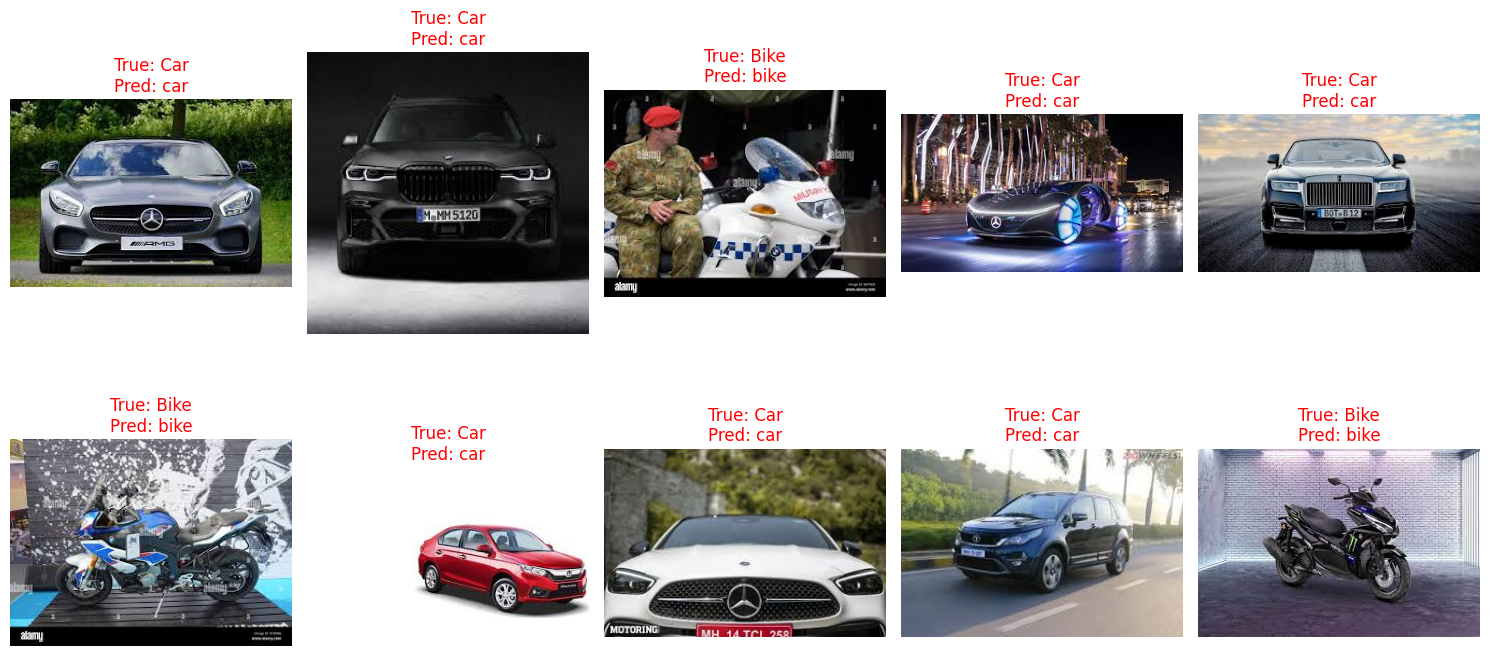

In [17]:

def visualize_wrong_predictions(model, directory, label_encoder, scaler, num_samples=10):
    image_paths = []
    labels = []
    wrong_images = []
    wrong_true_labels = []
    wrong_pred_labels = []

    for class_name in os.listdir(directory):
        class_folder = os.path.join(directory, class_name)
        if not os.path.isdir(class_folder):
            continue
        for img_file in os.listdir(class_folder):
            image_paths.append(os.path.join(class_folder, img_file))
            labels.append(class_name)

    indices = np.random.choice(len(image_paths), min(len(image_paths), 100), replace=False)

    for idx in indices:
        img_path = image_paths[idx]
        true_label = labels[idx]
        image = cv2.imread(img_path)
        gray = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
        gray = cv2.resize(gray, (128, 128))
        feature = hog(gray, orientations=12, pixels_per_cell=(16, 16),
                      cells_per_block=(3, 3), block_norm='L2-Hys', visualize=False)
        feature_scaled = scaler.transform([feature])
        pred = model.predict(feature_scaled)[0]
        pred_label = label_encoder.inverse_transform([pred])[0]

        if true_label != pred_label:
            wrong_images.append(image)
            wrong_true_labels.append(true_label)
            wrong_pred_labels.append(pred_label)

        if len(wrong_images) >= num_samples:
            break

    plt.figure(figsize=(15, 8))
    for i, (img, true_label, pred_label) in enumerate(zip(wrong_images, wrong_true_labels, wrong_pred_labels)):
        image_rgb = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
        plt.subplot(2, 5, i + 1)
        plt.imshow(image_rgb)
        plt.title(f"True: {true_label}\nPred: {pred_label}", color='red')
        plt.axis('off')

    plt.tight_layout()
    plt.show()

visualize_wrong_predictions(rf_model, val_dir, le, scaler)